In [3]:
# grab image files in data
# resize them to 1024 pixels height, keep aspect ratio

import os
import sys
from PIL import Image
import matplotlib.pyplot as plt

def resize_image(input_image_path, desired_height, output_image_path=None):
    original_image = Image.open(input_image_path)
    # rotate image if it is not in portrait mode
    width, height = original_image.size
    print(width, height)
    # scale image to desired height
    if height > width:
        width = int(width * desired_height / height)
        height = desired_height
        print(width, height)
        resized_image = original_image.resize((width, height))
        # resized_image.save(output_image_path)
    else:
        height = int(height * desired_height / width)
        width = desired_height
        print(width, height)
        resized_image = original_image.resize((width, height))
        # rotate image if it is not in portrait mode
        resized_image = resized_image.rotate(-90, expand=True)

    if output_image_path is not None:
        resized_image.save(output_image_path)
    return resized_image

            

15 IMG_0328.JPEG
4032 3024
2000 1500


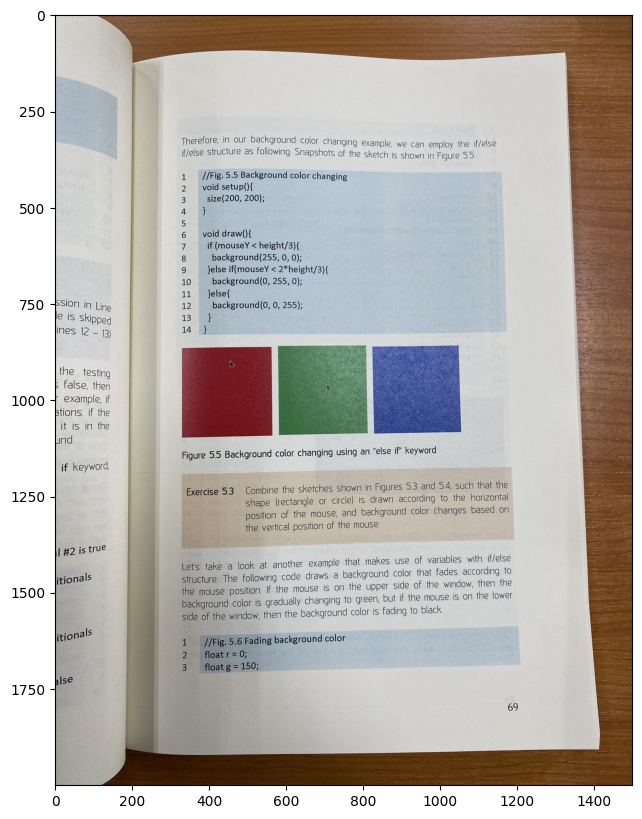

In [4]:
input_dir = 'data'
output_dir = 'data_resized'
# if not os.path.exists(output_dir):
    # os.makedirs(output_dir)
for i, filename in enumerate(os.listdir(input_dir)):
    if filename.endswith('.JPEG') and i == 15:
        print(i, filename)
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)
        resized_image = resize_image(input_image_path, 2000)
        # show image
        # make figsize=(10, 10)
        plt.figure(figsize=(10, 10))
        plt.imshow(resized_image)
        plt.show()
    # break

In [5]:
import cv2
import numpy as np
from scipy.ndimage import map_coordinates

def detect_text_lines(gray_image):
    # Apply a binary threshold to get a binary image
    _, binary = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)
    
    # Use morphological operations to emphasize text lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    dilated = cv2.dilate(binary, kernel, iterations=2)
    
    # Find contours corresponding to the text lines
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

def fit_curve_to_lines(contours):
    curves = []
    for contour in contours:
        x = contour[:, 0, 0]
        y = contour[:, 0, 1]
        
        # Fit a second-degree polynomial (quadratic curve) to the text line
        if len(x) > 1:
            curve = np.polyfit(x, y, 2)
            curves.append(curve)
    
    return curves

def dewarp_image(image, curves):
    h, w = image.shape[:2]
    map_x = np.zeros((h, w), dtype=np.float32)
    map_y = np.zeros((h, w), dtype=np.float32)
    
    for i in range(h):
        for j in range(w):
            # Apply the inverse polynomial transformation to dewarp
            y_prime = i
            x_prime = j
            
            for curve in curves:
                y_prime -= np.polyval(curve, x_prime) - i
            
            map_x[i, j] = x_prime
            map_y[i, j] = y_prime
    
    # Remap the original image based on the calculated mapping
    dewarped_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    
    return dewarped_image

def dewarp_curl(image_path):
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
    else:
        image = np.array(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect text lines
    contours = detect_text_lines(gray)
    print('contours:', len(contours))
    
    # Fit curves to each text line
    curves = fit_curve_to_lines(contours)
    print('curves:', len(curves))
    
    # Dewarp the image based on the detected curves
    dewarped_image = dewarp_image(image, curves)
    
    return dewarped_image

# Example usage:
image_path = resize_image('data/IMG_0335.JPEG', 2000)
dewarped_image = dewarp_curl(image_path)
cv2.imshow('Dewarped Image', dewarped_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


ImportError: libGL.so.1: cannot open shared object file: No such file or directory